## Visual Input Labels

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo

In [10]:
# User Edits

detrend    = 0
target     = np.load('../../CESM_data/CESM_label_amv_index_detrend%i.npy'%detrend)
outfigpath = "../../CESM_data/Figures/"
lead=0
percent_train=0.8
tstep=86
ens=40
thresholds = [-1,1]

In [11]:
def make_classes(y,thresholds,exact_value=False,reverse=False,return_counts=False):
    """
    Makes classes based on given thresholds. 

    Parameters
    ----------
    y : ARRAY
        Labels to classify
    thresholds : ARRAY
        1D Array of thresholds to partition the data
    exact_value: BOOL, optional
        Set to True to use the exact value in thresholds (rather than scaling by
                                                          standard deviation)
    return_counts: BOOL, optional
        Set to True to return the count of points for each class
    
    Returns
    -------
    y_class : ARRAY [samples,class]
        Classified samples, where the second dimension contains an integer
        representing each threshold

    """
    nthres = len(thresholds)
    if ~exact_value: # Scale thresholds by standard deviation
        y_std = np.std(y) # Get standard deviation
        thresholds = np.array(thresholds) * y_std
    y_class  = np.zeros((y.shape[0],1))
    y_counts = np.zeros((nthres+1))
    if nthres == 1: # For single threshold cases
        thres = thresholds[0]
        y_class[y<=thres] = 0
        y_class[y>thres] = 1
        
        print("Class 0 Threshold is y <= %.2f " % (thres))
        print("Class 0 Threshold is y > %.2f " % (thres))
        return y_class
    
    for t in range(nthres+1):
        if t < nthres:
            thres = thresholds[t]
        else:
            thres = thresholds[-1]
        
        if reverse: # Assign class 0 to largest values
            tassign = nthres-t
        else:
            tassign = t
        
        if t == 0: # First threshold
            y_class[y<=thres] = tassign
            y_counts[tassign] = (y<=thres).sum()
            print("Class %i Threshold is y <= %.2f ; %i points found." % (tassign,thres,y_counts[tassign]))
        elif t == nthres: # Last threshold
            y_class[y>thres] = tassign
            y_counts[tassign] = (y>thres).sum()
            print("Class %i Threshold is y > %.2f; %i points found." % (tassign,thres,y_counts[tassign]))
        else: # Intermediate values
            thres0 = thresholds[t-1]
            y_class[(y>thres0) * (y<=thres)] = tassign
            y_counts[tassign] = ((y>thres0) * (y<=thres)).sum()
            print("Class %i Threshold is %.2f < y <= %.2f ; %i points found." % (tassign,thres0,thres,y_counts[tassign]))
    if return_counts:
        return y_class,y_counts
    return y_class


In [12]:
y       = target[:ens,lead:].reshape(ens*(tstep-lead),1)

y_class,y_counts = make_classes(y,thresholds,reverse=True,return_counts=True)

y_std = 0.3625

y_counts/len(y)

Class 2 Threshold is y <= -0.36 ; 507 points found.
Class 1 Threshold is -0.36 < y <= 0.36 ; 2390 points found.
Class 0 Threshold is y > 0.36; 543 points found.


array([0.15784884, 0.69476744, 0.14738372])

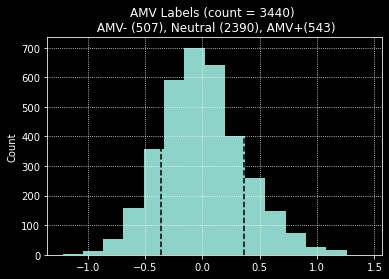

In [13]:
# Plot whole dataset 

countlabels = ["AMV+","Neutral","AMV-"]

fig,ax = plt.subplots(1,1)

ax.set_ylabel("Count")

ax.hist(y,bins=15)
ax.set_title("AMV Labels (count = %i) \n AMV- (%i), Neutral (%i), AMV+(%i)" % (len(y),y_counts[2],y_counts[1],y_counts[0]))
ax.grid(True,ls='dotted')
ax.vlines([-y_std,y_std],ymin=0,ymax=500,color='k',ls='dashed')

plt.savefig("%sAMVLabel_Distr.png"%outfigpath,dpi=200)

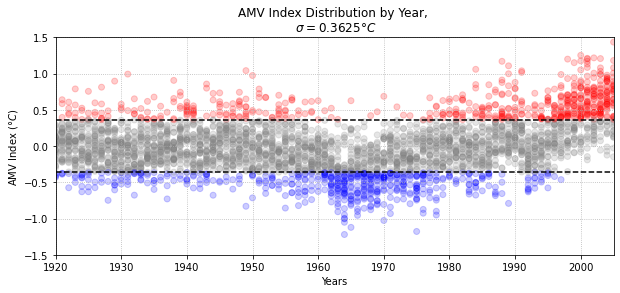

In [6]:
# View in a timeseries sense
yrs = np.arange(1920,2006,1)


fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.grid(True,ls='dotted')
for i in range(ens):
    plotdata = target[i,:]
    col = np.where(plotdata<=-y_std,'b',np.where(plotdata>y_std,'r','gray'))
    ax.scatter(yrs,plotdata,c=col,alpha=0.2)
ax.hlines([-y_std,y_std],xmin=1920,xmax=2005,color='k',ls='dashed')
ax.set_ylabel("AMV Index ($\degree C$)")
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Years")
ax.set_xlim([yrs[0],yrs[-1]])

ax.set_xticks(np.arange(1920,2005,10))
ax.set_title("AMV Index Distribution by Year, \n $\sigma=%.4f \degree C$"% (y_std))
plt.savefig("%sAMV_Index_intime.png"%outfigpath,dpi=200)

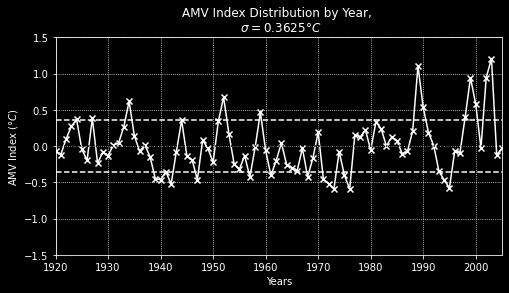

In [8]:
# View in a timeseries sense

yrs = np.arange(1920,2006,1)

plt.style.use('dark_background')
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.grid(True,ls='dotted')
for i in range(ens):
    plotdata = target[i,:]
    #col = np.where(plotdata<=-y_std,'cornflowerblue',np.where(plotdata>y_std,'r','gray'))
    #ax.scatter(yrs,plotdata,c=col,alpha=0.4)
ax.plot(yrs,target[0,:],color="w")
ax.hlines([-y_std,y_std],xmin=1920,xmax=2005,color='w',ls='dashed')
ax.scatter(yrs,target[0,:],color='w',marker="x")
ax.axhline(0,color='k',ls='dotted')
ax.set_ylabel("AMV Index ($\degree C$)")
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Years")
ax.set_xlim([yrs[0],yrs[-1]])

ax.set_xticks(np.arange(1920,2005,10))
ax.set_title("AMV Index Distribution by Year, \n $\sigma=%.4f \degree C$"% (y_std))
plt.savefig("%sAMV_Index_intime.png"%outfigpath,dpi=150,transparent=True)

In [69]:
y_train = y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].astype(np.float32).squeeze()
y_val   = y[int(np.floor(percent_train*(tstep-lead)*ens)):,:].astype(np.float32).squeeze()

y_std = np.std(y)
y_std

0.3624689697971061

In [72]:
target.shape

(40, 86)

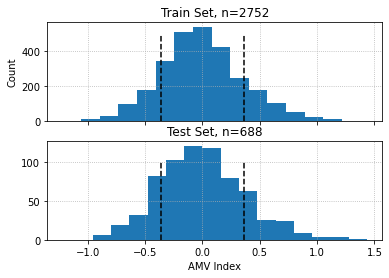

In [26]:
# Distribution of AMV Index

fig,ax = plt.subplots(2,1,sharex=True)

ax[0].set_ylabel("Count")

ax[0].hist(y_train,bins=15)
ax[0].set_title("Train Set, n=%i"%len(y_train))
ax[0].grid(True,ls='dotted')
ax[0].vlines([-y_std,y_std],ymin=0,ymax=500,color='k',ls='dashed')



ax[1].set_xlabel("AMV Index")
ax[1].hist(y_val,bins=15)
ax[1].set_title("Test Set, n=%i"%len(y_val))
ax[1].grid(True,ls='dotted')
ax[1].vlines([-y_std,y_std],ymin=0,ymax=100,color='k',ls='dashed')

plt.savefig("%sTrain_Test_Distr.png"%outfigpath,dpi=200)

## Visualize AMV Inputs


In [17]:
%%time
detrend    = 0
resolution = "2deg"
data    = np.load('../../CESM_data/CESM_data_sst_sss_psl_deseason_normalized_resized_detrend%i.npy'%detrend)
target  = np.load('../../CESM_data/CESM_label_amv_index_detrend%i.npy'%detrend)
lon     = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat     = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
data.shape,target.shape

CPU times: user 2.06 ms, sys: 914 ms, total: 916 ms
Wall time: 919 ms


((3, 40, 86, 224, 224), (40, 86))

In [18]:
# Remake Lat/Lon grid
latr = np.linspace(lat[0],lat[-1],224)
lonr = np.linspace(lon[0],lon[-1],224)

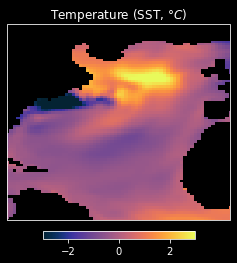

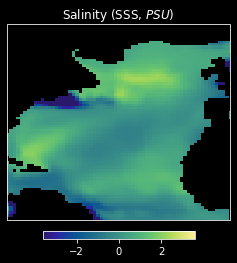

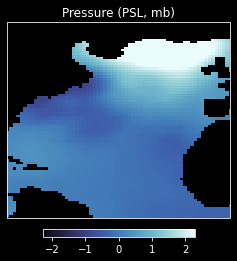

In [21]:
# Plot the Input variable

yid = 0
eid = 0
v   = 0

cmaps  = (cmo.cm.thermal,cmo.cm.haline,cmo.cm.ice)
vnames = ("Temperature (SST, $\degree C$)","Salinity (SSS, $PSU$)","Pressure (PSL, mb)")
vnameshort = ("SST","SSS","PSL")

for v in range(3):
    cmap  = cmaps[v]
    vname = vnames[v]

    fig,ax = plt.subplots(1,1,figsize=(4,4),subplot_kw={'projection':ccrs.PlateCarree()})

    ax.set_extent([-80,0,0,65])
    

    data_in = data[v,eid,yid,...].copy()
    data_in[np.abs(data_in)<1e-4] = np.nan
    
    vmax    = 3*np.nanstd(np.abs(data_in.flatten())) 
    pcm = plt.pcolormesh(lonr,latr,data_in,cmap=cmap,vmin=-vmax,vmax=vmax)
    cb = fig.colorbar(pcm,ax=ax,fraction =0.035,orientation='horizontal',pad=0.05)
    ax.add_feature(cfeature.LAND,color='k')
    ax.set_title(vname)
    plt.savefig("../../CESM_Data/Figures/Varslice_yrid%i_ensid%i_%s" % (yid,eid,vnameshort[v]),dpi=100,bbox_inches='tight', transparent=True)

array([ 0.        ,  0.28699552,  0.57399103,  0.86098655,  1.14798206,
        1.43497758,  1.72197309,  2.00896861,  2.29596413,  2.58295964,
        2.86995516,  3.15695067,  3.44394619,  3.7309417 ,  4.01793722,
        4.30493274,  4.59192825,  4.87892377,  5.16591928,  5.4529148 ,
        5.73991031,  6.02690583,  6.31390135,  6.60089686,  6.88789238,
        7.17488789,  7.46188341,  7.74887892,  8.03587444,  8.32286996,
        8.60986547,  8.89686099,  9.1838565 ,  9.47085202,  9.75784753,
       10.04484305, 10.33183857, 10.61883408, 10.9058296 , 11.19282511,
       11.47982063, 11.76681614, 12.05381166, 12.34080717, 12.62780269,
       12.91479821, 13.20179372, 13.48878924, 13.77578475, 14.06278027,
       14.34977578, 14.6367713 , 14.92376682, 15.21076233, 15.49775785,
       15.78475336, 16.07174888, 16.35874439, 16.64573991, 16.93273543,
       17.21973094, 17.50672646, 17.79372197, 18.08071749, 18.367713  ,
       18.65470852, 18.94170404, 19.22869955, 19.51569507, 19.80